In [1]:
from optimizers.objective_functions.objective_functions import *
from optimizers.genetic_algorithms.chromossomes import *
from optimizers.genetic_algorithms.offspring_control import *
from optimizers.genetic_algorithms.sorter import *
import numpy as np
import pandas as pd
from pycaret.regression import *
import plotly.express as px
import plotly.figure_factory as ff


In [2]:
model_lgbm_0=load_model("models/lgbm_v0")
model_lgbm_1=load_model("models/lgbm_v1")
model_lasso_0=load_model("models/lasso_v0")
#model_lasso_1=load_model("models/lasso_v1")

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [3]:
df_material=pd.DataFrame([['AISI_1045', 0.25, 1000, -1, 5, 209.3996337890626, 553.0, 600.0,0.0134, 0.234, 1.0],
                          ['AISI_4140', 0.25, 1000, -4, 5, 1147.44189453125, 595.0, 580.0,0.023, 0.133, 1.03],
                          ['AISI_4340', 0.25, 1000, -4, 5, 584.8319091796877, 792.0, 510.0,0.014, 1.03, 0.26],
                          ['AISI_52100', 0.25, 1000, -4, 5, 253.8834747314454, 774.78, 134.0,0.0018, 0.37, 3.171],
                          ['AISI_304', 0.25, 1000, -4, 5, 739.4136962890625, 310.0, 1000.0,0.07, 0.65, 1.0],
                          ['AISI_1020', 0.25, 1000, -4, 5, 80.56342620849611, 213.0, 53.0,0.0055, 0.34, 0.81],],
              columns=["material","depth","vc","rake_angle","clearance_angle","expected_cut_force",
                        "A","B","C","n","m"])
df_material

material  depth    vc  rake_angle  clearance_angle  expected_cut_force  \
0   AISI_1045   0.25  1000          -1                5          209.399634   
1   AISI_4140   0.25  1000          -4                5         1147.441895   
2   AISI_4340   0.25  1000          -4                5          584.831909   
3  AISI_52100   0.25  1000          -4                5          253.883475   
4    AISI_304   0.25  1000          -4                5          739.413696   
5   AISI_1020   0.25  1000          -4                5           80.563426   

        A       B       C      n      m  
0  553.00   600.0  0.0134  0.234  1.000  
1  595.00   580.0  0.0230  0.133  1.030  
2  792.00   510.0  0.0140  1.030  0.260  
3  774.78   134.0  0.0018  0.370  3.171  
4  310.00  1000.0  0.0700  0.650  1.000  
5  213.00    53.0  0.0055  0.340  0.810

### Teste de otimização com GA para um modelo de machine learning

Para esse teste vamos fixar os parâmetros referentes ao material e só iremos otimizar o parâmetros depth,vc,rake_angle.

In [4]:
def build_input(controlable_input, fixed_input,construct_dict):
    final_input_df=pd.DataFrame()
    for input in controlable_input:
        for counter,parameter in enumerate(construct_dict.keys()):
            fixed_input[parameter]=input[counter]
        final_input_df=pd.concat([final_input_df,fixed_input])
    return final_input_df

In [5]:
model_lasso_0.named_steps["trained_model"].__class__.__name__

'Lasso'

In [6]:
model_lgbm_0.named_steps["trained_model"].__class__.__name__

'LGBMRegressor'

In [7]:
def objective_function_with_penalties(model,inputs):
    #ToDo: construir uma função que replique a Maximiação do MMR com restrição na potência conforme feito para a otimização teórica.
    pass

In [8]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems import get_problem
from pymoo.core.callback import Callback
from pymoo.termination.default import DefaultSingleObjectiveTermination

class MyProblem_simple(Problem):

    def __init__(self):
        super().__init__(n_var=2,       
                         n_obj=1,       
                         n_constr=0,    
                         xl=np.array([-10, -10]),  
                         xu=np.array([10, 10]))  
        
        self.obj_func=model_lasso_0

    def _evaluate(self, x, out, *args, **kwargs):

        predictions = np.array([np.sum(x**2,axis=1)])
        
        out["F"] = predictions 

class MyCallback(Callback):
    def __init__(self,material_code,model):
        super().__init__()
        self.data["n_gen"] = []
        self.data["f_best"] = []
        self.data["X"] = []
        self.material_code=material_code
        self.model=model

    def notify(self, algorithm):
        n_gen = algorithm.n_gen
        f_best = algorithm.opt[0].F[0]
        X = algorithm.pop.get("X")
        self.data["n_gen"].append(n_gen)
        self.data["f_best"].append(f_best)
        self.data["X"].append(X.copy())
        print(f"Geração {n_gen}: Melhor F = {f_best}")

# Definição do problema
class MyProblem(Problem):

    def __init__(self,material_code,model):
        super().__init__(n_var=2,       # Número de variáveis
                         n_obj=1,       # Número de objetivos
                         n_constr=0,    # Número de restrições
                         xl=np.array([-10, 1000]),  # Limites inferiores
                         xu=np.array([10, 5000]))  # Limites superiores
        
        self.obj_func=model
        self.material_code=material_code

    def _evaluate(self, x, out, *args, **kwargs):
        # x é uma matriz onde cada linha é uma solução e cada coluna é uma variável
        # Certifique-se de que x esteja no formato correto para o modelo
        # Se necessário, ajuste o formato de x aqui
        # Calcula a previsão do lasso_v0 para cada solução

        construct_dict={"rake_angle":{"sequence_len":4,"max_bound":10,"lower_bound":-10,"type":"int","neg_allowed":True},
                        "vc":{"sequence_len":15,"max_bound":10000,"lower_bound":500,"type":"int","neg_allowed":False},
                        #"depth":{"sequence_len":4,"max_bound":2,"lower_bound":0.1,"type":"float"}
                        }
        pd_inputs=build_input(x,df_material.iloc[[self.material_code]],construct_dict)

        predictions = predict_model(self.obj_func,pd_inputs.reset_index(drop=True))

        # Define a função objetivo
        out["F"] = predictions[["prediction_label"]].values  # Minimizar a previsão do modelo

        # Define as restrições (por exemplo, x1 + x2 >= 100)
        #g1 = 100 - (x[:, 0] + x[:, 1])
        #out["G"] = g1  # Restrições devem ser <= 0

# Instancia o problema

callback,problem,res = {},{},{}
pop_size={"Lasso":10,
          "LGBMRegressor":20}
generations={"Lasso":30,
             "LGBMRegressor":100}

termination = DefaultSingleObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-6,
    ftol=1e-3,
    period=20,
    n_max_gen=generations,
    n_max_evals=100
)


#problem = MyProblem_simple()
for material_index,material_name in enumerate(df_material["material"].unique()):
    callback[material_name],problem[material_name],res[material_name] = {},{},{}
    for model_artifact in [model_lasso_0,model_lgbm_0]:
        model_name=model_artifact.named_steps["trained_model"].__class__.__name__

        callback[material_name][model_name] = MyCallback(material_index,model_name)
        problem[material_name][model_name] = MyProblem(material_index,model_artifact)

        # Configura o algoritmo NSGA-II
        #algorithm = GA(pop_size=20, eliminate_duplicates=True) #NSGA2(pop_size=2)
        algorithm = NSGA2(pop_size=pop_size[model_name],eliminate_duplicates=True)

        # Executa a otimização
        res[material_name][model_name] = minimize(problem[material_name][model_name],
                                      algorithm,
                                      ("n_gen", generations[model_name]), #termination,  # Número de gerações
                                      verbose=True,
                                      seed=1,
                                      save_history=True,
                                      callback=callback[material_name][model_name],
                                      )

        # Resultados
        print("Melhor solução encontrada para material %s para modelo %s: \nX = %s\nF = %s" % (material_name,
                                                                                               model_name, 
                                                                                               res[material_name][model_name].X, 
                                                                                               res[material_name][model_name].F))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      1 |             - |             -
Geração 1: Melhor F = 224.36695125815123
     2 |       20 |      1 |  0.4300879790 |         ideal
Geração 2: Melhor F = 223.93686327919625
     3 |       30 |      1 |  0.000000E+00 |             f
Geração 3: Melhor F = 223.93686327919625
     4 |       40 |      1 |  0.2564784931 |         ideal
Geração 4: Melhor F = 223.68038478610123
     5 |       50 |      1 |  0.6622697559 |         ideal
Geração 5: Melhor F = 223.01811503022964
     6 |       60 |      1 |  0.2777140048 |         ideal
Geração 6: Melhor F = 222.74040102542108
     7 |       70 |      1 |  0.0325501871 |         ideal
Geração 7: Melhor F = 222.70785083830708
     8 |       80 |      1 |  1.6027602611 |         ideal
Geração 8: Melhor F = 221.1050905772263
     9 |       90 |      1 |  0.7012072520 |         ideal
Geração 9: Melhor F = 220.40388332522326
    10 |      100 |      1 |  0.1531300619

In [29]:
res

{'AISI_1045': {'Lasso': <pymoo.core.result.Result at 0x30113e8d0>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x306790790>},
 'AISI_4140': {'Lasso': <pymoo.core.result.Result at 0x306b77790>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x3082c8110>},
 'AISI_4340': {'Lasso': <pymoo.core.result.Result at 0x30854e6d0>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x309aecf90>},
 'AISI_52100': {'Lasso': <pymoo.core.result.Result at 0x30a214b90>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x30b528150>},
 'AISI_304': {'Lasso': <pymoo.core.result.Result at 0x30b8a95d0>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x30d0eec10>},
 'AISI_1020': {'Lasso': <pymoo.core.result.Result at 0x30d56dc10>,
  'LGBMRegressor': <pymoo.core.result.Result at 0x30ede8650>}}

In [31]:
for item in res.items():
    material_name=item[0]
    for subitem in item[1].items():
        if len(subitem[1].X)<=2:
            print("Melhor solução encontrada para material %s para modelo %s: \nX = %s\nF = %s" % (material_name,
                                                                                               subitem[0], 
                                                                                               subitem[1].X, 
                                                                                               subitem[1].F))
        else:
            print("Melhor solução encontrada para material %s para modelo %s: \nX = %s\nF = %s" % (material_name,
                                                                                               subitem[0], 
                                                                                               subitem[1].X[0], 
                                                                                               subitem[1].F[0]))            

Melhor solução encontrada para material AISI_1045 para modelo Lasso: 
X = [-7.80725244e-01  1.00010289e+03]
F = [215.07392256]
Melhor solução encontrada para material AISI_1045 para modelo LGBMRegressor: 
X = [  -8.29518561 4820.76812955]
F = [205.32118328]
Melhor solução encontrada para material AISI_4140 para modelo Lasso: 
X = [  -3.10673699 1000.00011103]
F = [1124.25853806]
Melhor solução encontrada para material AISI_4140 para modelo LGBMRegressor: 
X = [   6.61905741 4999.75211308]
F = [238.46658499]
Melhor solução encontrada para material AISI_4340 para modelo Lasso: 
X = [  -9.99999783 1000.00000971]
F = [547.7331199]
Melhor solução encontrada para material AISI_4340 para modelo LGBMRegressor: 
X = [   2.94771675 2656.57916092]
F = [573.27569966]
Melhor solução encontrada para material AISI_52100 para modelo Lasso: 
X = [   7.63368701 1000.00761539]
F = [274.44412876]
Melhor solução encontrada para material AISI_52100 para modelo LGBMRegressor: 
X = [   9.96697421 1426.4416703

In [10]:
import plotly.graph_objects as go
import plotly.express as px

# Criar uma figura com Plotly
fig = go.Figure()

# Gerar uma lista de cores com base no número total de combinações de material e modelo
color_palette = px.colors.qualitative.Plotly

color_index = 0
for material, data_raw in callback.items():
    for model_name, data in data_raw.items():
        # Atribuir uma cor da paleta
        color = color_palette[color_index % len(color_palette)]
        color_index += 1

        # Adicionar a curva ao gráfico
        fig.add_trace(go.Scatter(
            x=data.data["n_gen"], 
            y=data.data["f_best"], 
            mode='lines+markers',
            name=f'{material} - {model_name}',
            line=dict(color=color)
        ))

# Configurar os rótulos, título e layout do gráfico
fig.update_layout(
    title="Convergência da Função Objetivo para Diferentes Materiais e Modelos",
    xaxis_title="Geração",
    yaxis_title="Melhor Valor da Função Objetivo",
    legend_title="Material - Modelo",
    template="plotly_white",
    width=1000,
    height=600
)

# Mostrar o gráfico
fig.show()


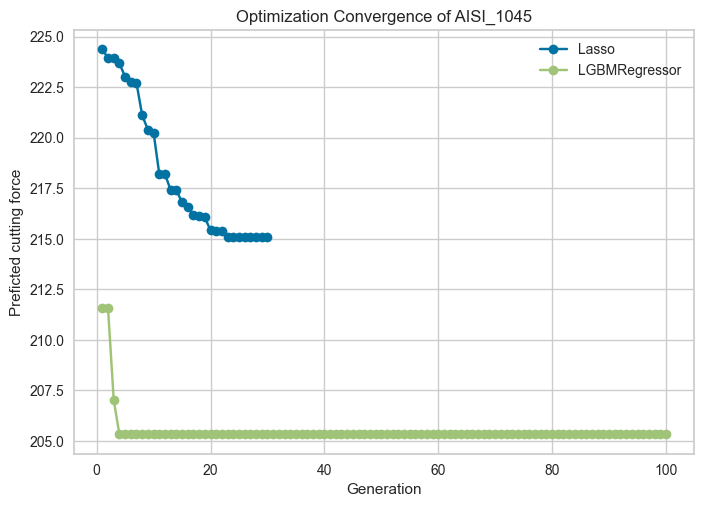

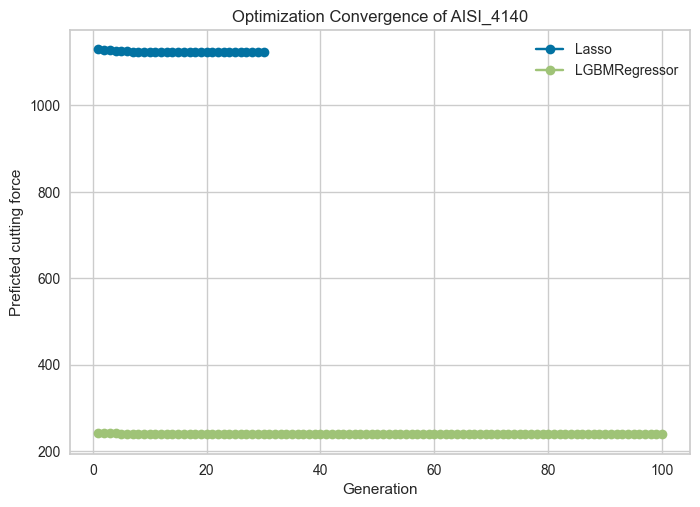

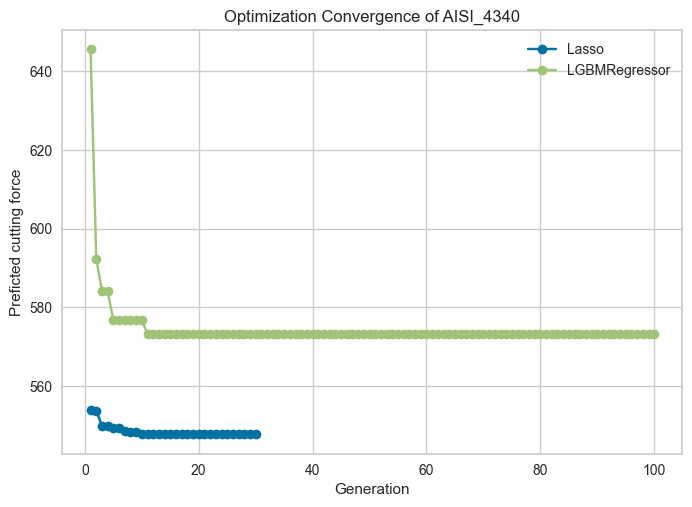

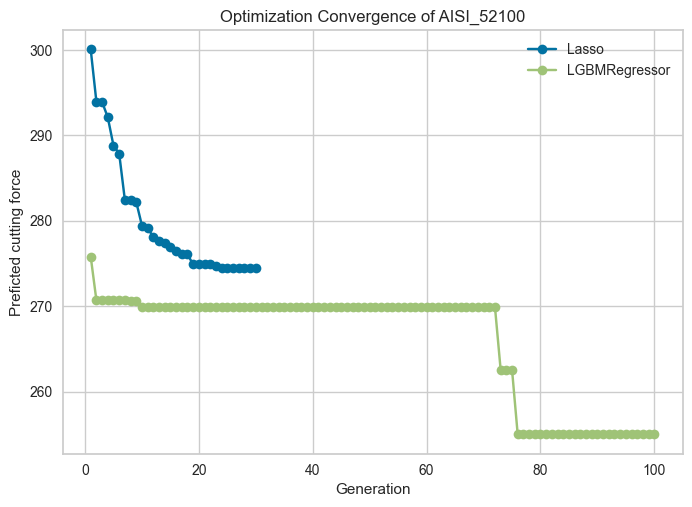

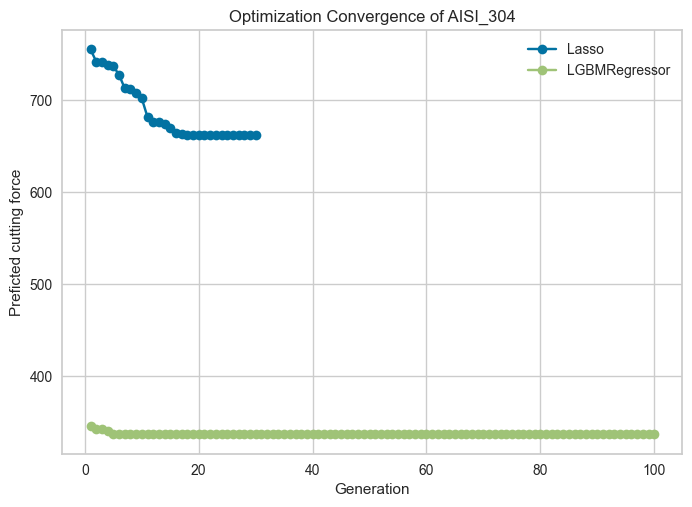

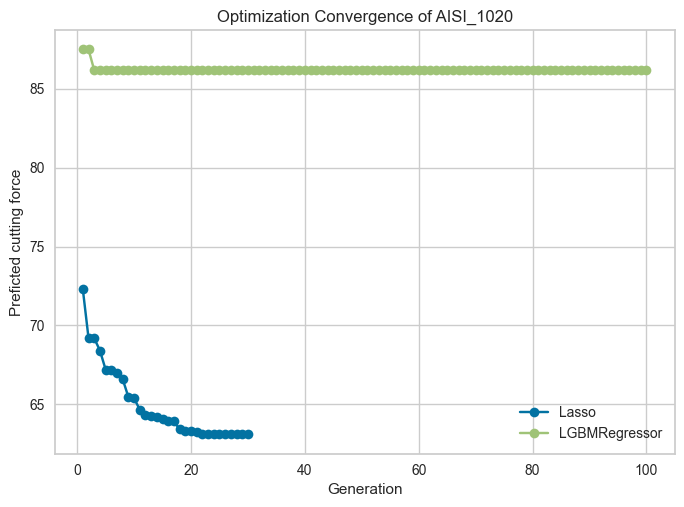

In [13]:
import matplotlib.pyplot as plt

for material,data_raw in callback.items():
    plt.figure()
    for model_name,data in data_raw.items():
        plt.plot(data.data["n_gen"], data.data["f_best"], marker='o')
        plt.title(f'Optimization Convergence of {material}')
        plt.xlabel('Generation')
        plt.ylabel('Preficted cutting force')
        plt.grid(True)
    plt.legend(data_raw.keys())
    plt.show()

In [16]:
colors = [
    # Tons de Azul e Roxo
    #"navy", "midnightblue", "darkblue", "mediumblue", "blue",
    #"slateblue", "darkslateblue", "mediumpurple", "rebeccapurple",
    #"blueviolet", "indigo", "darkorchid", "darkviolet", "mediumslateblue",
    
    # Tons de Verde
    "forestgreen", "darkgreen", "green", "seagreen",
    "mediumseagreen", "darkolivegreen", "olive", "darkcyan", "teal",
    
    # Tons de Cinza
    "dimgray", "gray", "darkgray", "slategray",
    "darkslategray", "black",
    
    # Tons de Marrom
    "saddlebrown", "sienna", "chocolate", "peru", "tan", "darkgoldenrod",
    
    # Tons de Amarelo Escuro/Dourado
    "goldenrod", "darkkhaki", "olive",
    
    # Tons de Azul-Esverdeado
    "darkturquoise", "mediumturquoise", "teal",
    "cadetblue", "steelblue", "lightseagreen"
]


In [17]:
res[material_name][model_name].X

array([-7.80725244e-01,  1.00010289e+03])

In [18]:
df_material

material  depth    vc  rake_angle  clearance_angle  expected_cut_force  \
0   AISI_1045   0.25  1000          -1                5          209.399634   
1   AISI_4140   0.25  1000          -4                5         1147.441895   
2   AISI_4340   0.25  1000          -4                5          584.831909   
3  AISI_52100   0.25  1000          -4                5          253.883475   
4    AISI_304   0.25  1000          -4                5          739.413696   
5   AISI_1020   0.25  1000          -4                5           80.563426   

        A       B       C      n      m  
0  553.00   600.0  0.0134  0.234  1.000  
1  595.00   580.0  0.0230  0.133  1.030  
2  792.00   510.0  0.0140  1.030  0.260  
3  774.78   134.0  0.0018  0.370  3.171  
4  310.00  1000.0  0.0700  0.650  1.000  
5  213.00    53.0  0.0055  0.340  0.810

In [19]:
pd.set_option("display.max_rows",500)

AISI_1045 Lasso


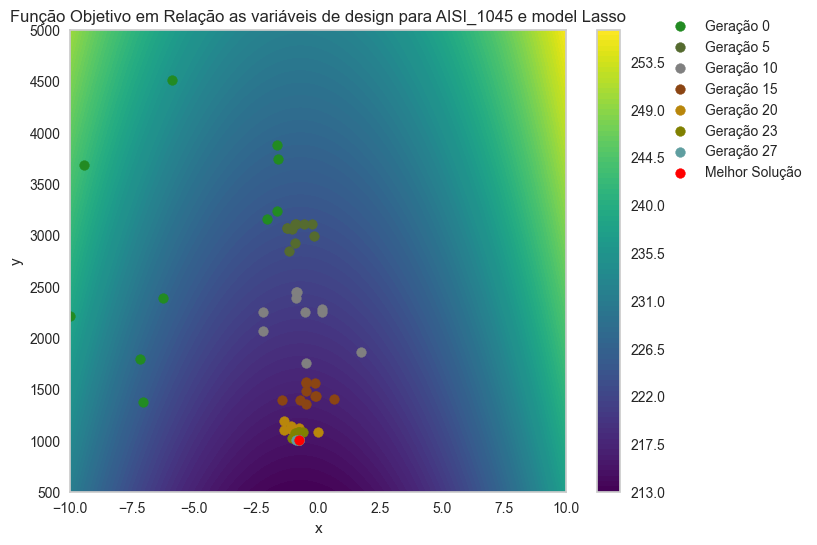

AISI_1045 LGBMRegressor
[205.32118328]


AISI_4140 Lasso


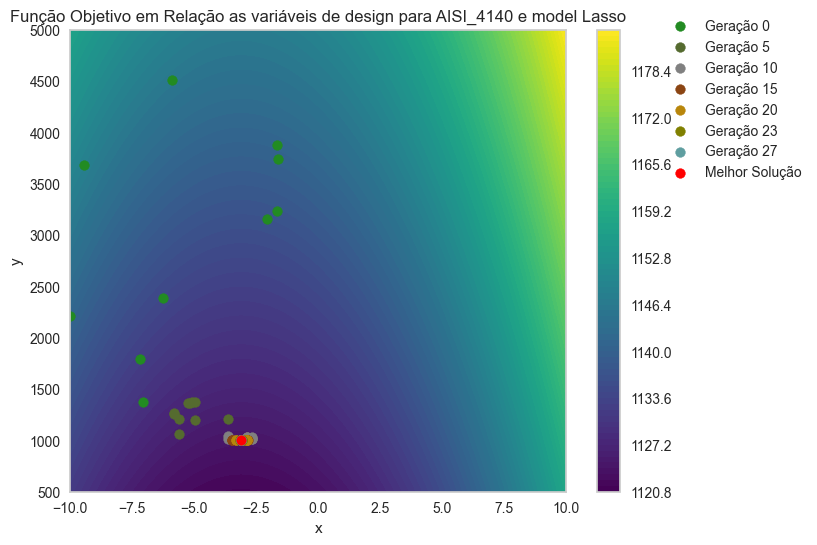

AISI_4140 LGBMRegressor
[238.46658499]


AISI_4340 Lasso


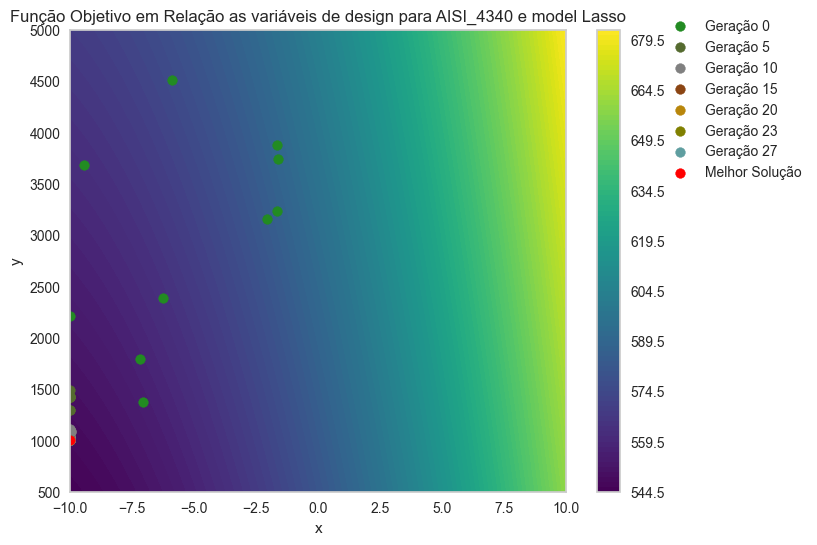

AISI_4340 LGBMRegressor
[573.27569966]


AISI_52100 Lasso


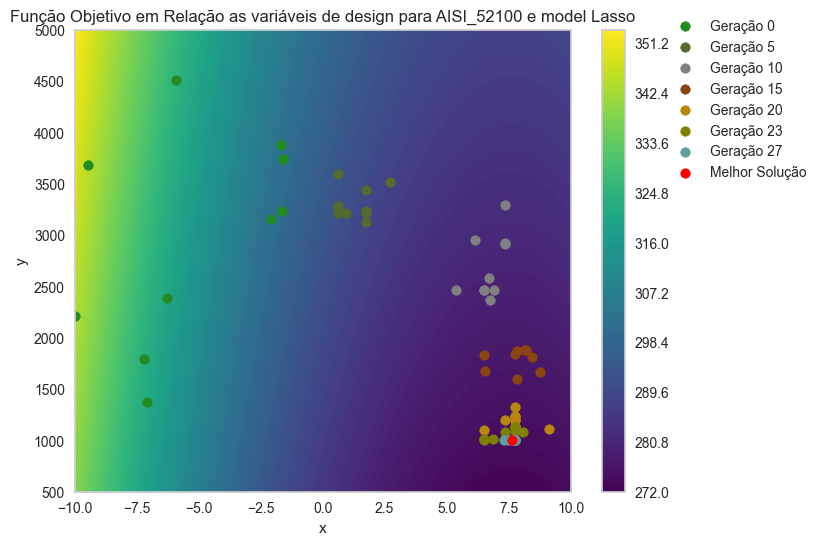

AISI_52100 LGBMRegressor
[254.99140448]


AISI_304 Lasso


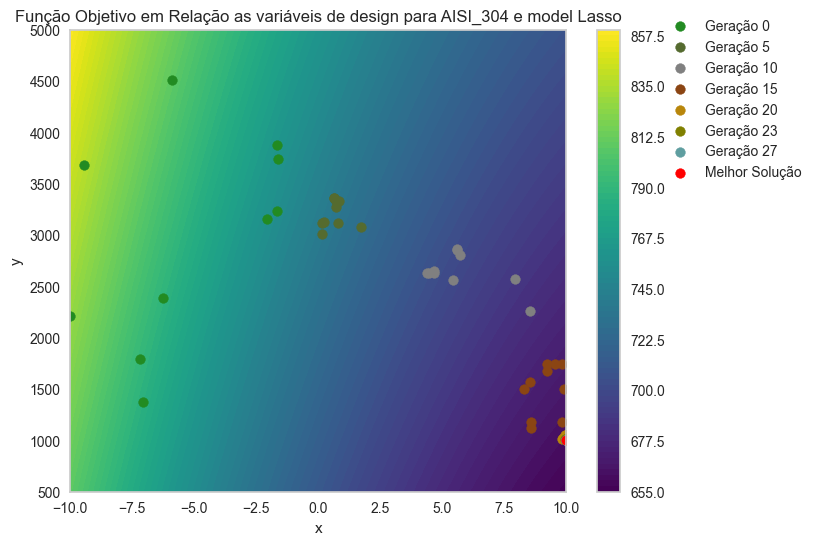

AISI_304 LGBMRegressor
[337.0530434]


AISI_1020 Lasso


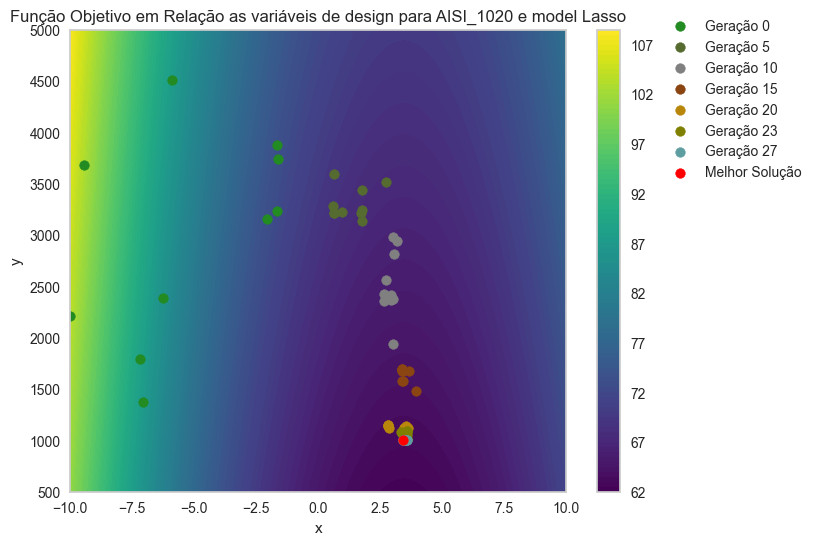

AISI_1020 LGBMRegressor
[86.17062919]


In [26]:
import numpy as np
import plotly.graph_objects as go

x_min, x_max = -10, 10
y_min, y_max = 500, 5000

x_values = np.linspace(x_min, x_max, 100)
y_values = np.linspace(y_min, y_max, 100)
X_grid, Y_grid = np.meshgrid(x_values, y_values)

input_data = np.column_stack((X_grid.ravel(), Y_grid.ravel()))
construct_dict={"rake_angle":{"sequence_len":4,"max_bound":10,"lower_bound":-10,"type":"int","neg_allowed":True},
                "vc":{"sequence_len":15,"max_bound":10000,"lower_bound":500,"type":"int","neg_allowed":False},
                #"depth":{"sequence_len":4,"max_bound":2,"lower_bound":0.1,"type":"float"}
                }

for material_index,material_name in enumerate(df_material["material"].unique()):
    for model_artifact in [model_lasso_0,model_lgbm_0]:
        model_name=model_artifact.named_steps["trained_model"].__class__.__name__
        print(material_name, model_name)
        pd_inputs=build_input(input_data,df_material.iloc[[material_index]],construct_dict)
        predictions = predict_model(model_artifact,pd_inputs.reset_index(drop=True))["prediction_label"].values

        Z = np.array([predictions])
        Z = Z.reshape(X_grid.shape)

        if model_name in ["Lasso"]:
            plt.figure(figsize=(8, 6))
            contour = plt.contourf(X_grid, Y_grid, Z, levels=100, cmap='viridis')
            plt.colorbar(contour)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title(f'Função Objetivo em Relação as variáveis de design para {material_name} e model {model_name}')

            for counter,gen_candidates in enumerate(callback[material_name][model_name].data["X"]):
                if counter in [0,5,10,15,20,23,27]:
                    data_gen=build_input(gen_candidates,df_material.iloc[[material_index]],construct_dict)
                    plt.scatter(data_gen["rake_angle"], data_gen["vc"],color=colors[counter], label=f'Geração {counter}')
            if len(res[material_name][model_name].X)>2:
                best_point_possible=res[material_name][model_name].X[0]
            else:
                best_point_possible=res[material_name][model_name].X
            plt.scatter(best_point_possible[0], best_point_possible[1], color='red', label='Melhor Solução')
            plt.legend(bbox_to_anchor=(1.5, 1.05))
            plt.show()
        else:
            # Create the 3D contour plot
            fig = go.Figure(data=go.Surface(z=Z, x=X_grid, y=Y_grid, colorscale='Viridis'))

            # Update layout
            fig.update_layout(
                title=f'Função Objetivo em Relação as variáveis de design para {material_name} e model {model_name}',
                scene=dict(
                    xaxis_title="Rake Angle",
                    yaxis_title="VC",
                    zaxis_title="Predicted cutting force"
                ),
                width=800,
                height=400,
                margin=dict(l=10, r=10, t=30, b=10)  # Margens ajustadas para reduzir espaço

            )

            for counter,gen_candidates in enumerate(callback[material_name][model_name].data["X"]):
                if counter in [0,5,10,15,20,23,27]:
                    data_gen=build_input(gen_candidates,df_material.iloc[[material_index]],construct_dict)

                    fig.add_trace(go.Scatter3d(
                        x=data_gen["rake_angle"],
                        y= data_gen["vc"],
                        z=predict_model(model_artifact,data_gen.reset_index(drop=True))["prediction_label"].values,
                        mode='markers',
                        marker=dict(size=8, color=colors[counter]),
                        name='Candidate Solutions'
                        )
                    )

            if len(res[material_name][model_name].X)>2:
                best_point_possible=res[material_name][model_name].X[0]
                z_candidates=res[material_name][model_name].F[0]
            else:
                best_point_possible=res[material_name][model_name].X
                z_candidates=res[material_name][model_name].F
            print(z_candidates)
            fig.add_trace(go.Scatter3d(
                x=[best_point_possible[0]],
                y=[best_point_possible[1]],
                z=z_candidates,
                mode='markers',
                marker=dict(size=8, color='red'),
                name='Best Solutions'
                )
            )
            # Show the plot
            #plt.scatter(best_point_possible[0], best_point_possible[1], color='red', label='Melhor Solução')
            #plt.legend(bbox_to_anchor=(1.5, 1.05))
            fig.update_layout(
                legend=dict(
                    x=-0.1,  # Move a legenda para a esquerda
                    y=1,     # Posição vertical
                    bgcolor='rgba(255, 255, 255, 0.5)',  # Cor de fundo transparente (opcional)
                )
            )
            fig.show()